In [17]:
from gensim.models import Doc2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import glob
import numpy as np
import pandas as pd
import cv2

In [18]:
from keras.layers import Input, merge, Concatenate, Dense, Dropout, Conv2D, Add, Dot, Lambda, Conv2DTranspose, Dot, Activation, Reshape, BatchNormalization, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Multiply, LeakyReLU, Flatten, MaxPool2D, MaxPool3D, Embedding, GRU
from keras.layers.convolutional import Convolution2D, UpSampling2D, SeparableConv2D
from keras.layers import PReLU, LeakyReLU
from keras.models import Model
from keras.models import load_model
import keras.backend as K
from keras import layers
from keras.preprocessing.sequence import pad_sequences

from nltk.tokenize import sent_tokenize, word_tokenize 
import tensorflow as tf

In [19]:
img_paths = glob.glob('cleaned-data\*.jpg')

In [20]:
img_paths

['cleaned-data\\000000000009.jpg',
 'cleaned-data\\000000000025.jpg',
 'cleaned-data\\000000000030.jpg',
 'cleaned-data\\000000000034.jpg',
 'cleaned-data\\000000000036.jpg',
 'cleaned-data\\000000000042.jpg',
 'cleaned-data\\000000000049.jpg',
 'cleaned-data\\000000000061.jpg',
 'cleaned-data\\000000000064.jpg',
 'cleaned-data\\000000000071.jpg',
 'cleaned-data\\000000000072.jpg',
 'cleaned-data\\000000000073.jpg',
 'cleaned-data\\000000000074.jpg',
 'cleaned-data\\000000000077.jpg',
 'cleaned-data\\000000000078.jpg',
 'cleaned-data\\000000000081.jpg',
 'cleaned-data\\000000000086.jpg',
 'cleaned-data\\000000000089.jpg',
 'cleaned-data\\000000000092.jpg',
 'cleaned-data\\000000000094.jpg',
 'cleaned-data\\000000000109.jpg',
 'cleaned-data\\000000000110.jpg',
 'cleaned-data\\000000000113.jpg',
 'cleaned-data\\000000000127.jpg',
 'cleaned-data\\000000000133.jpg',
 'cleaned-data\\000000000136.jpg',
 'cleaned-data\\000000000138.jpg',
 'cleaned-data\\000000000142.jpg',
 'cleaned-data\\0000

In [21]:
captions = pd.read_csv('./coco-captions-2017-clean.csv')

In [22]:
annot_list = captions.values[:1168]
data = [] 
corpus_dict = {}
# iterate through each caption 
max_sequence_length = float("-inf")
for row in annot_list: 
    temp = [] 
      
    #tokenize the captions into words 
    for j in word_tokenize(row[2]): 
        temp.append(j.lower()) 
        corpus_dict[j.lower()] = 0
    if len(temp) > max_sequence_length:
        max_sequence_length = len(temp)
    data.append(temp) 

for index, word in enumerate(corpus_dict.keys()):
    corpus_dict[word] = index + 1
    
corpus_size = len(corpus_dict.keys())

In [14]:
corpus_size

1563

In [23]:
captions_X = []
caption_strings = []

for row in annot_list:
    caption_conv = []
    for word in word_tokenize(row[2].lower()):
        caption_conv.append(corpus_dict[word])
    captions_X.append(np.array(caption_conv))
    
    
    

In [24]:
captions_X = pad_sequences(captions_X, maxlen=27, value=0, padding='post')

In [25]:
captions_X = np.array(captions_X)

In [29]:
annot_df = pd.read_csv('./coco-captions-2017-clean.csv')
annot_list = annot_df.values[:1167]
data = [] 
corpus_dict = {}
# iterate through each caption 
max_sequence_length = float("-inf")
for row in annot_list: 
    temp = [] 
      
    #tokenize the captions into words 
    for j in word_tokenize(row[2]): 
        temp.append(j.lower()) 
        corpus_dict[j.lower()] = 0
    if len(temp) > max_sequence_length:
        max_sequence_length = len(temp)
    data.append(temp) 
  
for index, word in enumerate(corpus_dict.keys()):
    corpus_dict[word] = index + 1
    
corpus_size = len(corpus_dict.keys())
print("corpus size: {}".format(corpus_size))
print("max sequence length: {}".format(max_sequence_length))

corpus size: 1563
max sequence length: 27


In [30]:
def data_loader(file_path):
    img_paths = glob.glob(file_path + '/*')
    data = []
    for img_path in img_paths:
        
        data.append(cv2.imread(img_path) / 255.0)
    return np.array(data)

In [31]:
imgs_y = data_loader('./cleaned-data/')

In [32]:
autoencoder = load_model('./autoencoder-models-fixed-images/autoencoder-28k-epochs.h5')

In [10]:
decoder = autoencoder.layers[2]

In [11]:
for layer in decoder.layers:
    layer.trainable = False
decoder.trainable = False

In [3]:
def build_intermediate_model(input_shape, name='textencoder', encode_channels=[4, 8, 16, 32]):
    embedding_size = 32
    input_length = 27
    input_layer = Input(shape=input_shape)
    encoder_block = Embedding(1168, embedding_size, input_length=27)(input_layer)
    
    
    
    for i in range(input_length):
        
        word = Lambda(lambda x : x[:,i,:])(encoder_block)
        
        # first word in sequence
        word = Reshape((-1,32))(word)
        
        if(i == 0):
            _, state_i = GRU(64, return_state=True, name=str(i)+'_GRU')(word)
        else:
            embedded_seq, state_i = GRU(64, return_state=True, name=str(i)+"_GRU")(word, initial_state=state_i)
 
            
        
        
        
        

    encoder_block = Reshape((8, 8, 1))(embedded_seq)
    encoder_block = Conv2DTranspose(1, 3, strides=2, padding='same', activation='tanh')(encoder_block)
    
    for index, channel in enumerate(encode_channels):
        encoder_block = Conv2D(channel, 3, strides=1, padding='same', activation='tanh')(encoder_block)

    
    output_layer = encoder_block
    return Model(input_layer, output_layer, name=name)

In [4]:
model_intermediate = build_intermediate_model((27,), encode_channels=[4, 6, 8, 12, 16, 24, 32])

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
model_intermediate.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 27)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 27, 32)       37376       input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 32)           0           embedding_1[0][0]                
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 32)           0           embedding_1[0][0]                
__________________________________________________________________________________________________
reshape_1 

In [12]:
def build_autoencoder():
    input_caption = Input(shape=(27,))
    latent_representation = model_intermediate(input_caption)
    decoded_img = decoder(latent_representation)
    autoencoder = Model(input_caption, decoded_img, name="text2img")
    return autoencoder

In [13]:
model_text2img = build_autoencoder()

In [ ]:
model_text2img.summary()

In [288]:
model_text2img.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [289]:
tx = captions_X[:100]
ty = imgs_y[:100]

In [295]:
for i in range (2, 20):
    history = model_text2img.fit(captions_X, imgs_y, epochs=10000, batch_size=128, shuffle=True)
    model_text2img.save('.\\text2img-models\\text2img-' + str(i) + 'k-epochs.h5')

Epoch 1/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4637
Epoch 2/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4608
Epoch 3/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4574
Epoch 4/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4575
Epoch 5/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4604
Epoch 6/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4636
Epoch 7/10000
1168/1168 [==============================] - ETA: 0s - loss: 0.0753 - acc: 0.465 - 1s 1ms/step - loss: 0.0751 - acc: 0.4655
Epoch 8/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4619
Epoch 9/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4572
Epoch 10/10000
1168/1168 [==============================] - 1s

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4621
Epoch 162/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4630
Epoch 163/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4609
Epoch 164/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4636
Epoch 165/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4643
Epoch 166/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4582
Epoch 167/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4611
Epoch 168/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4599
Epoch 169/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4569
Epoch 170/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4581
Epoch 322/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4556
Epoch 323/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4552
Epoch 324/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4626
Epoch 325/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4602
Epoch 326/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4600
Epoch 327/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4656
Epoch 328/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4610
Epoch 329/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4544
Epoch 330/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4583
Epoch 482/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4561
Epoch 483/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4589
Epoch 484/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4635
Epoch 485/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4621
Epoch 486/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4606
Epoch 487/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4579
Epoch 488/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4586
Epoch 489/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4600
Epoch 490/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4634
Epoch 642/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4603
Epoch 643/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4594
Epoch 644/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4577
Epoch 645/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4557
Epoch 646/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4628
Epoch 647/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4650
Epoch 648/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4608
Epoch 649/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4583
Epoch 650/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4649
Epoch 802/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4645
Epoch 803/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4601
Epoch 804/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4590
Epoch 805/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4645
Epoch 806/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4630
Epoch 807/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4632
Epoch 808/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4633
Epoch 809/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4615
Epoch 810/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4589
Epoch 962/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4609
Epoch 963/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4605
Epoch 964/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4591
Epoch 965/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4603
Epoch 966/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4626
Epoch 967/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4611
Epoch 968/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4625
Epoch 969/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4630
Epoch 970/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4641
Epoch 1042/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4659
Epoch 1043/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4625
Epoch 1044/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4602
Epoch 1045/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4579
Epoch 1046/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4605
Epoch 1047/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4633
Epoch 1048/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4639
Epoch 1049/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4603
Epoch 1050/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4621
Epoch 1200/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4625
Epoch 1201/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4625
Epoch 1202/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4608
Epoch 1203/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4581
Epoch 1204/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4633
Epoch 1205/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4616
Epoch 1206/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4625
Epoch 1207/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4608
Epoch 1208/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4624
Epoch 1358/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4638
Epoch 1359/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4574
Epoch 1360/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4537
Epoch 1361/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4562
Epoch 1362/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4589
Epoch 1363/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4634
Epoch 1364/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4590
Epoch 1365/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4577
Epoch 1366/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4629
Epoch 1516/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4543
Epoch 1517/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4589
Epoch 1518/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4638
Epoch 1519/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4628
Epoch 1520/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4603
Epoch 1521/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4597
Epoch 1522/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4613
Epoch 1523/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4633
Epoch 1524/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4563
Epoch 1674/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4625
Epoch 1675/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4627
Epoch 1676/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4600
Epoch 1677/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4645
Epoch 1678/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4583
Epoch 1679/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4607
Epoch 1680/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4636
Epoch 1681/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4649
Epoch 1682/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

Epoch 1831/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4621
Epoch 1832/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4586
Epoch 1833/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4581
Epoch 1834/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4545
Epoch 1835/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4528
Epoch 1836/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4586
Epoch 1837/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4640
Epoch 1838/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4613
Epoch 1839/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4616
Epoch 1840/10000
1168/1168 [==============================] - 1s 1ms/step

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4653
Epoch 1990/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4639
Epoch 1991/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4594
Epoch 1992/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4588
Epoch 1993/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4608
Epoch 1994/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4584
Epoch 1995/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4615
Epoch 1996/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4611
Epoch 1997/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4619
Epoch 1998/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4624
Epoch 2148/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4625
Epoch 2149/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4604
Epoch 2150/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4613
Epoch 2151/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4634
Epoch 2152/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4587
Epoch 2153/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4604
Epoch 2154/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4629
Epoch 2155/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4632
Epoch 2156/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4641
Epoch 2306/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4554
Epoch 2307/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4593
Epoch 2308/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4620
Epoch 2309/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4643
Epoch 2310/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4647
Epoch 2311/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4607
Epoch 2312/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4594
Epoch 2313/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4618
Epoch 2314/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4625
Epoch 2464/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4624
Epoch 2465/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4651
Epoch 2466/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4601
Epoch 2467/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4589
Epoch 2468/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4613
Epoch 2469/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4560
Epoch 2470/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4582
Epoch 2471/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4607
Epoch 2472/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4621
Epoch 2622/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4605
Epoch 2623/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4579
Epoch 2624/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4622
Epoch 2625/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4571
Epoch 2626/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4577
Epoch 2627/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4646
Epoch 2628/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4616
Epoch 2629/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4636
Epoch 2630/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4639
Epoch 2780/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4643
Epoch 2781/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4619
Epoch 2782/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4595
Epoch 2783/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4638
Epoch 2784/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4620
Epoch 2785/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4571
Epoch 2786/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4631
Epoch 2787/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4650
Epoch 2788/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4582
Epoch 2938/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4627
Epoch 2939/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4616
Epoch 2940/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4631
Epoch 2941/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4649
Epoch 2942/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4591
Epoch 2943/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4596
Epoch 2944/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4597
Epoch 2945/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4569
Epoch 2946/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4618
Epoch 3096/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4574
Epoch 3097/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4563
Epoch 3098/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4599
Epoch 3099/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4612
Epoch 3100/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4589
Epoch 3101/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4583
Epoch 3102/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4623
Epoch 3103/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4512
Epoch 3104/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4579
Epoch 3254/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4595
Epoch 3255/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4608
Epoch 3256/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4550
Epoch 3257/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4586
Epoch 3258/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4613
Epoch 3259/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4619
Epoch 3260/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4610
Epoch 3261/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4646
Epoch 3262/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4648
Epoch 3412/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4621
Epoch 3413/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4588
Epoch 3414/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4585
Epoch 3415/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4610
Epoch 3416/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4598
Epoch 3417/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4593
Epoch 3418/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4637
Epoch 3419/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4614
Epoch 3420/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4620
Epoch 3570/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4592
Epoch 3571/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4569
Epoch 3572/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4601
Epoch 3573/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4616
Epoch 3574/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4593
Epoch 3575/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4560
Epoch 3576/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4578
Epoch 3577/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4591
Epoch 3578/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

Epoch 3727/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4615
Epoch 3728/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4539
Epoch 3729/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4596
Epoch 3730/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4638
Epoch 3731/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4621
Epoch 3732/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4600
Epoch 3733/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4527
Epoch 3734/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4529
Epoch 3735/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4556
Epoch 3736/10000
1168/1168 [==============================] - 1s 1ms/step

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4658
Epoch 3886/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4618
Epoch 3887/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4588
Epoch 3888/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4604
Epoch 3889/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4572
Epoch 3890/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4560
Epoch 3891/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4570
Epoch 3892/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4571
Epoch 3893/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4596
Epoch 3894/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4633
Epoch 4044/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4629
Epoch 4045/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4613
Epoch 4046/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4622
Epoch 4047/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4623
Epoch 4048/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4621
Epoch 4049/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4630
Epoch 4050/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4570
Epoch 4051/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4567
Epoch 4052/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4591
Epoch 4202/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4649
Epoch 4203/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4648
Epoch 4204/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4625
Epoch 4205/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4530
Epoch 4206/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4563
Epoch 4207/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4604
Epoch 4208/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4634
Epoch 4209/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4619
Epoch 4210/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4622
Epoch 4360/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4629
Epoch 4361/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4635
Epoch 4362/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4640
Epoch 4363/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4625
Epoch 4364/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4570
Epoch 4365/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4596
Epoch 4366/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4547
Epoch 4367/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4570
Epoch 4368/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4583
Epoch 4518/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4598
Epoch 4519/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4619
Epoch 4520/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4645
Epoch 4521/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4613
Epoch 4522/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4626
Epoch 4523/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4666
Epoch 4524/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4641
Epoch 4525/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4642
Epoch 4526/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4598
Epoch 4676/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4656
Epoch 4677/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4571
Epoch 4678/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4616
Epoch 4679/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4572
Epoch 4680/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4569
Epoch 4681/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4651
Epoch 4682/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4648
Epoch 4683/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4664
Epoch 4684/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4568
Epoch 4834/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4631
Epoch 4835/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4613
Epoch 4836/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4612
Epoch 4837/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4606
Epoch 4838/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4615
Epoch 4839/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4605
Epoch 4840/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4520
Epoch 4841/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4552
Epoch 4842/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4592
Epoch 4992/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4615
Epoch 4993/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4592
Epoch 4994/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4575
Epoch 4995/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4615
Epoch 4996/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4625
Epoch 4997/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4618
Epoch 4998/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4584
Epoch 4999/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4592
Epoch 5000/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4524
Epoch 5150/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4506
Epoch 5151/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4589
Epoch 5152/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4636
Epoch 5153/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4621
Epoch 5154/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4623
Epoch 5155/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4643
Epoch 5156/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4619
Epoch 5157/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4615
Epoch 5158/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4609
Epoch 5308/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4531
Epoch 5309/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4595
Epoch 5310/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4634
Epoch 5311/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4652
Epoch 5312/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4658
Epoch 5313/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4620
Epoch 5314/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4620
Epoch 5315/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4629
Epoch 5316/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4629
Epoch 5466/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4628
Epoch 5467/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4634
Epoch 5468/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4621
Epoch 5469/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4613
Epoch 5470/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4607
Epoch 5471/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4588
Epoch 5472/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4581
Epoch 5473/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4570
Epoch 5474/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4618
Epoch 5624/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4619
Epoch 5625/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4612
Epoch 5626/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4623
Epoch 5627/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4636
Epoch 5628/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4615
Epoch 5629/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4560
Epoch 5630/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4568
Epoch 5631/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4604
Epoch 5632/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4637
Epoch 5782/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4581
Epoch 5783/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4602
Epoch 5784/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4578
Epoch 5785/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4529
Epoch 5786/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4578
Epoch 5787/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4630
Epoch 5788/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4601
Epoch 5789/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4583
Epoch 5790/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

Epoch 5860/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4628
Epoch 5861/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4577
Epoch 5862/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4594
Epoch 5863/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4572
Epoch 5864/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4530
Epoch 5865/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4649
Epoch 5866/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4639
Epoch 5867/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4622
Epoch 5868/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4591
Epoch 5869/10000
1168/1168 [==============================] - 1s 1ms/step

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4554
Epoch 6019/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4626
Epoch 6020/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4660
Epoch 6021/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4623
Epoch 6022/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4647
Epoch 6023/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4642
Epoch 6024/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4612
Epoch 6025/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4589
Epoch 6026/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4604
Epoch 6027/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4638
Epoch 6177/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4639
Epoch 6178/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4558
Epoch 6179/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4600
Epoch 6180/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4626
Epoch 6181/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4556
Epoch 6182/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4572
Epoch 6183/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4570
Epoch 6184/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4580
Epoch 6185/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4629
Epoch 6335/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4638
Epoch 6336/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4642
Epoch 6337/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4630
Epoch 6338/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4594
Epoch 6339/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4630
Epoch 6340/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4651
Epoch 6341/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4613
Epoch 6342/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4610
Epoch 6343/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4595
Epoch 6493/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4633
Epoch 6494/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4609
Epoch 6495/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4592
Epoch 6496/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4612
Epoch 6497/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4607
Epoch 6498/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4621
Epoch 6499/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4576
Epoch 6500/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4505
Epoch 6501/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4624
Epoch 6651/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4600
Epoch 6652/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4555
Epoch 6653/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4569
Epoch 6654/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4590
Epoch 6655/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4605
Epoch 6656/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4594
Epoch 6657/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4583
Epoch 6658/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4640
Epoch 6659/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4568
Epoch 6809/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4622
Epoch 6810/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4629
Epoch 6811/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4605
Epoch 6812/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4586
Epoch 6813/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4599
Epoch 6814/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4621
Epoch 6815/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4634
Epoch 6816/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4610
Epoch 6817/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4616
Epoch 6967/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4579
Epoch 6968/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4573
Epoch 6969/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4602
Epoch 6970/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4546
Epoch 6971/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4603
Epoch 6972/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4630
Epoch 6973/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4630
Epoch 6974/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4570
Epoch 6975/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4636
Epoch 7125/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4538
Epoch 7126/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4610
Epoch 7127/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4627
Epoch 7128/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4583
Epoch 7129/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4585
Epoch 7130/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4621
Epoch 7131/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4637
Epoch 7132/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4639
Epoch 7133/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4631
Epoch 7283/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4567
Epoch 7284/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4615
Epoch 7285/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4662
Epoch 7286/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4621
Epoch 7287/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4609
Epoch 7288/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4612
Epoch 7289/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4599
Epoch 7290/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4592
Epoch 7291/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4642
Epoch 7441/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4644
Epoch 7442/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4565
Epoch 7443/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4591
Epoch 7444/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4577
Epoch 7445/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4629
Epoch 7446/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4654
Epoch 7447/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4616
Epoch 7448/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4582
Epoch 7449/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4576
Epoch 7599/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4603
Epoch 7600/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4566
Epoch 7601/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4592
Epoch 7602/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4660
Epoch 7603/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4611
Epoch 7604/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4556
Epoch 7605/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4557
Epoch 7606/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4595
Epoch 7607/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4594
Epoch 7757/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4635
Epoch 7758/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4594
Epoch 7759/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4579
Epoch 7760/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4593
Epoch 7761/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4598
Epoch 7762/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4633
Epoch 7763/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4638
Epoch 7764/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4636
Epoch 7765/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4584
Epoch 7915/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4568
Epoch 7916/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4566
Epoch 7917/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4585
Epoch 7918/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4633
Epoch 7919/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4637
Epoch 7920/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4608
Epoch 7921/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4613
Epoch 7922/10000
1168/1168 [==============================] - ETA: 0s - loss: 0.0752 - acc: 0.456 - 1s 1ms/step - loss: 0.0751 - acc: 0.4562
Epoch 7923/10000
1168/1168 [========================

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4554
Epoch 8073/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4494
Epoch 8074/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4616
Epoch 8075/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4637
Epoch 8076/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4600
Epoch 8077/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4566
Epoch 8078/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4622
Epoch 8079/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4646
Epoch 8080/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4626
Epoch 8081/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4574
Epoch 8231/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4638
Epoch 8232/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4652
Epoch 8233/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4529
Epoch 8234/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4555
Epoch 8235/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4648
Epoch 8236/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4602
Epoch 8237/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4601
Epoch 8238/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4617
Epoch 8239/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4599
Epoch 8389/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4599
Epoch 8390/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4606
Epoch 8391/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4593
Epoch 8392/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4558
Epoch 8393/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4590
Epoch 8394/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4626
Epoch 8395/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4624
Epoch 8396/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4613
Epoch 8397/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4625
Epoch 8547/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4646
Epoch 8548/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4611
Epoch 8549/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4597
Epoch 8550/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4630
Epoch 8551/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4612
Epoch 8552/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4564
Epoch 8553/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4636
Epoch 8554/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4665
Epoch 8555/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4624
Epoch 8705/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4591
Epoch 8706/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4622
Epoch 8707/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4633
Epoch 8708/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4610
Epoch 8709/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0752 - acc: 0.4612
Epoch 8710/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4627
Epoch 8711/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4577
Epoch 8712/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 - acc: 0.4568
Epoch 8713/10000
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0751 -

KeyboardInterrupt: 

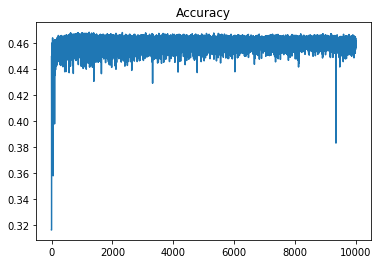

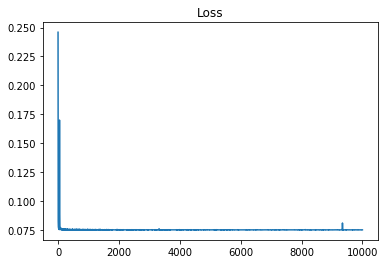

In [297]:
plot_history(history)

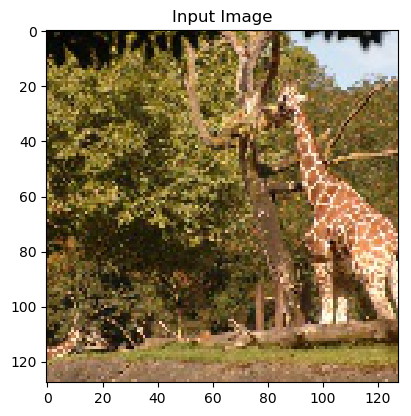

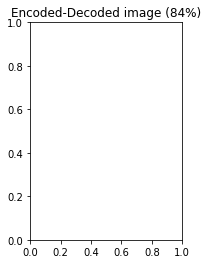

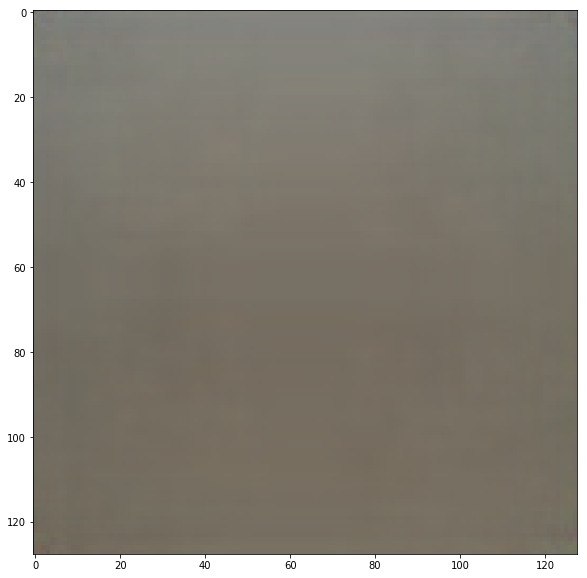

([], <a list of 0 Text yticklabel objects>)

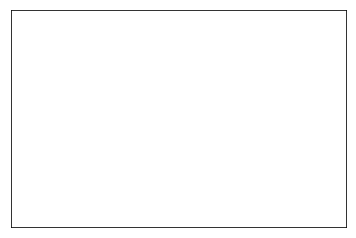

In [296]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
# figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
def rgb_imshow(img):
    plt.imshow(cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.show()

img_index = 1
# print(caption_strings[img_index])
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
img_input = imgs_y[img_index] #subset_X[img_index]
plt.subplot(1,2,1)
plt.title("Input Image")
rgb_imshow(img_input)
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.title("Encoded-Decoded image (84%)")
decoded_img = model_text2img.predict(np.array([captions_X[img_index]]))[0]

figure(num=None, figsize=(10, 10), facecolor='w', edgecolor='k')
rgb_imshow(decoded_img)


plt.xticks([])
plt.yticks([])




In [115]:
model_text2img.predict(captions_X[img_index], steps=None)[0]

ValueError: Error when checking input: expected input_19 to have shape (27,) but got array with shape (1,)

In [87]:
def plot_history(history):
    plt.plot(history.history['acc'])
    plt.title("Accuracy")
    plt.show()
    plt.plot(history.history['loss'])
    plt.title("Loss")
    plt.show()

In [113]:
np.shape(model_text2img.predict(np.array([captions_X[0]]))[0])

(128, 128, 3)

In [16]:
from keras.utils import plot_model

plot_model(model_intermediate,  show_shapes=True, to_file='./vis/text2img-vis.jpg')